In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import warnings


In [2]:
train_Mortgage = pd.read_csv('train_Mortgage.csv')
val_Mortgage = pd.read_csv('val_Mortgage.csv')
train_Pension = pd.read_csv('train_Pension.csv')
val_Pension = pd.read_csv('val_Pension.csv')
train_Savings = pd.read_csv('train_Savings.csv')
val_Savings = pd.read_csv('val_Savings.csv')

In [3]:
train_Mortgage.head()

,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,Mortgage
0,43,15,43,0,0,0,0,45,38012,3,13,24,4,0,0,0,6,47,0.000,0
1,44,14,44,0,0,0,0,51,45479,7,6,12,3,1,0,0,8,39,0.000,0
2,25,0,25,1,0,0,0,52,31515,3,-1,0,3,5,0,0,12,34,0.000,0
3,40,5,40,1,0,0,0,69,30782,3,27,36,0,0,0,0,11,18,0.000,0
4,33,4,33,0,0,0,0,46,39377,5,33,36,3,2,4,2,14,38,8.585,0


для начала создадим param_grid для поиска наилучших параметров

In [4]:
models = {
      "Logistic Regression": LogisticRegression(),
}
param_grids = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        "solver": ["liblinear", "lbfgs"],
        "max_iter": [500, 1000, 15000]
    },
}

теперь обучим модели четырёх видов логистической регрессии. Их можно будет посмотреть в словаре models_mortgage

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss

# Optional: function to compute Expected Calibration Error (ECE)
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    n_samples = len(y_true)
    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.sum(mask) > 0:
            bin_acc = np.mean(y_true[mask])
            bin_conf = np.mean(y_prob[mask])
            ece += np.abs(bin_acc - bin_conf) * (np.sum(mask) / n_samples)
    return ece

# Main training and evaluation function
def train_and_evaluate_logistic_models(
    train: pd.DataFrame,
    val: pd.DataFrame,
    target: str,
    calibrate_methods=['sigmoid', 'isotonic'],
    random_state=42,
    importance_model: str = None
):

    X_train = train.drop(columns=[target])
    y_train = train[target].values
    X_val = val.drop(columns=[target])
    y_val = val[target].values

    X_tr, X_test, y_tr, y_test = train_test_split(
        X_train, y_train, test_size=0.3, random_state=random_state
    )

    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    variants = {
        'l2_lbfgs': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000),
        'l1_liblinear': LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000),
        'elasticnet_saga': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=5000)
    }
    param_grids = {
        'l2_lbfgs': {'C': [0.01, 0.1, 1, 10]},
        'l1_liblinear': {'C': [0.01, 0.1, 1, 10]},
        'elasticnet_saga': {'C': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7]}
    }

    results = {}
    plt.figure(figsize=(8, 6))
    for name, model in variants.items():
        print(f"Training variant: {name}")
        gs = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_tr_scaled, y_tr)
        best_est = gs.best_estimator_
        y_val_proba = best_est.predict_proba(X_val_scaled)[:, 1]
        auc = roc_auc_score(y_val, y_val_proba)
        fpr, tpr, _ = roc_curve(y_val, y_val_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        results[name] = {
            'model': best_est,
            'best_params': gs.best_params_,
            'roc_auc': auc,
            'y_val_proba': y_val_proba
        }
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC by Variant'); plt.legend(); plt.show()

    best_name = max(results, key=lambda k: results[k]['roc_auc'])
    if importance_model is None:
        im_name = best_name
    else:
        im_name = importance_model
        if im_name not in results:
            raise ValueError(f"importance_model {im_name} not found among variants")

    best_entry = results[best_name]
    selected_entry = results[im_name]
    model_selected = selected_entry['model']

    plt.figure(figsize=(12, 5))
    calib_metrics = {}
    for i, method in enumerate(calibrate_methods, 1):
        calib = CalibratedClassifierCV(best_entry['model'], method=method, cv='prefit')
        calib.fit(X_test_scaled, y_test)
        y_calib = calib.predict_proba(X_val_scaled)[:, 1]
        prob_true, prob_pred = calibration_curve(y_val, y_calib, n_bins=10)
        plt.subplot(1, len(calibrate_methods), i)
        plt.plot(prob_pred, prob_true, marker='o', label=method)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'Reliability ({method})')
        plt.xlabel('Mean predicted'); plt.ylabel('Fraction correct')
        brier = brier_score_loss(y_val, y_calib)
        ece = compute_ece(y_val, y_calib)
        calib_metrics[method] = {'brier': round(brier, 3), 'ece': round(ece, 3)}
        print(f"Calibration {method}: Brier={brier:.3f}, ECE={ece:.3f}")
    plt.tight_layout(); plt.show()

    coefs = pd.Series(model_selected.coef_[0], index=X_train.columns)
    top_feat = coefs.abs().nlargest(10)
    plt.figure(figsize=(8, 6))
    colors = ['green' if coefs[f] > 0 else 'red' for f in top_feat.index]
    top_feat.sort_values().plot(kind='barh', color=colors)
    plt.title(f'Top 10 Features for {im_name} (green=positive, red=negative)'); plt.show()

    summary = {
        'model_object': model_selected,
        'selected_model_name': im_name,
        'selected_params': selected_entry['best_params'],
        'selected_roc_auc': round(selected_entry['roc_auc'], 3),
        'calibration_metrics': calib_metrics,
        'top_features': top_feat
    }
    print('Summary for selected model:', summary)
    return summary





Training variant: l2_lbfgs
Training variant: l1_liblinear
Training variant: elasticnet_saga


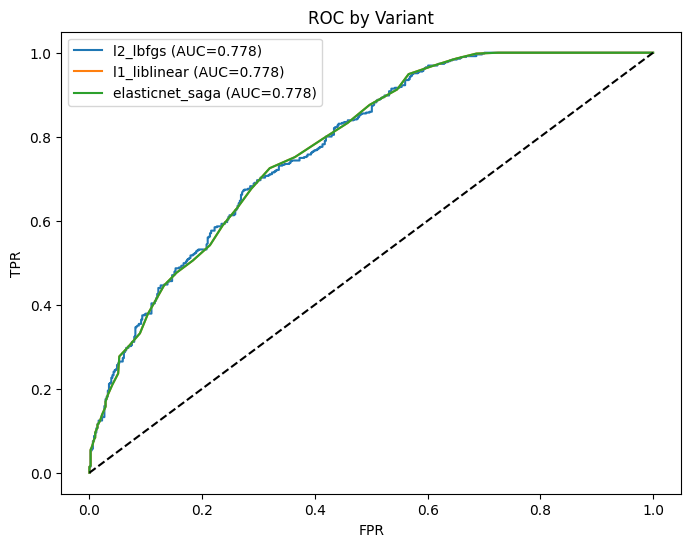

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibration sigmoid: Brier=0.256, ECE=0.244
Calibration isotonic: Brier=0.247, ECE=0.227


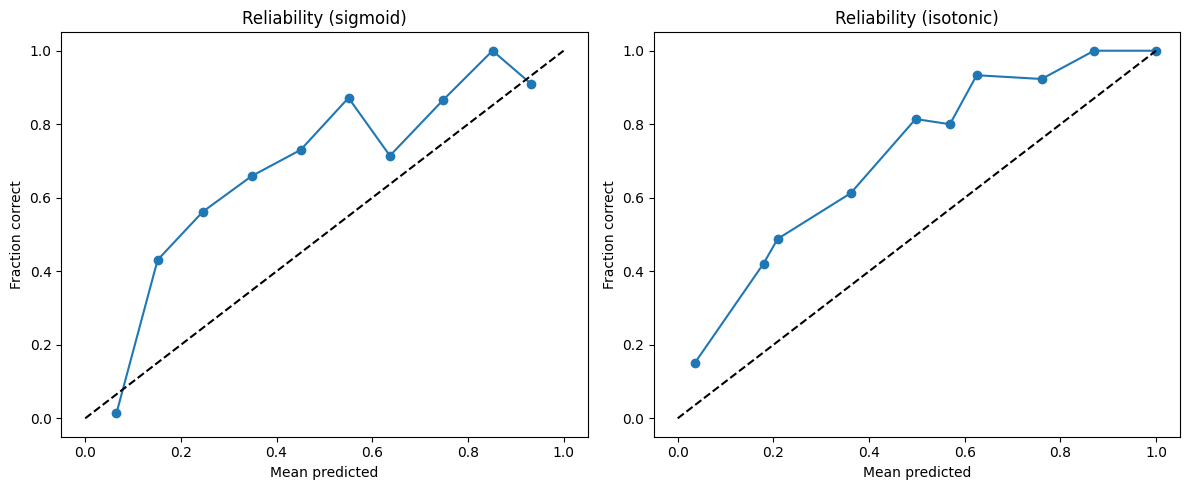

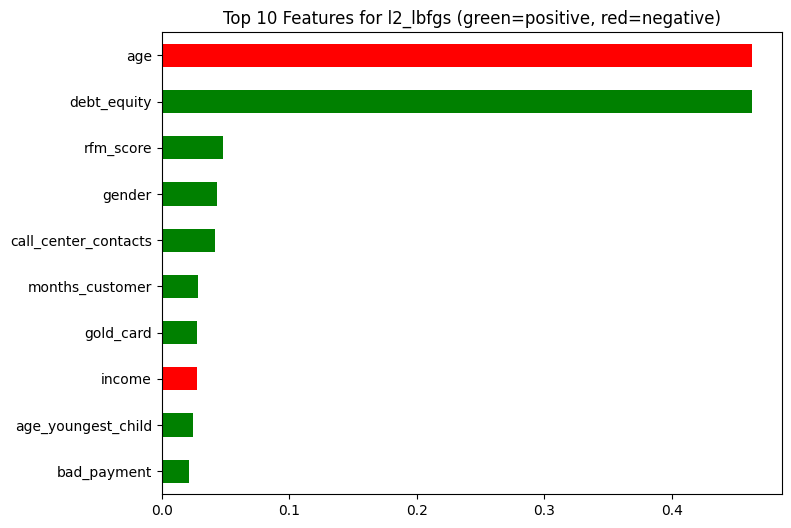

Summary for selected model: {'model_object': LogisticRegression(C=0.01, max_iter=5000), 'selected_model_name': 'l2_lbfgs', 'selected_params': {'C': 0.01}, 'selected_roc_auc': np.float64(0.778), 'calibration_metrics': {'sigmoid': {'brier': np.float64(0.256), 'ece': np.float64(0.244)}, 'isotonic': {'brier': np.float64(0.247), 'ece': np.float64(0.227)}}, 'top_features': age                     0.462902
debt_equity             0.462902
rfm_score               0.048076
gender                  0.043493
call_center_contacts    0.042115
months_customer         0.028626
gold_card               0.027819
income                  0.027687
age_youngest_child      0.024824
bad_payment             0.021792
dtype: float64}


In [24]:
models_Pension = train_and_evaluate_logistic_models(train_Pension, val_Pension, "Pension")

Training variant: l2_lbfgs
Training variant: l1_liblinear
Training variant: elasticnet_saga


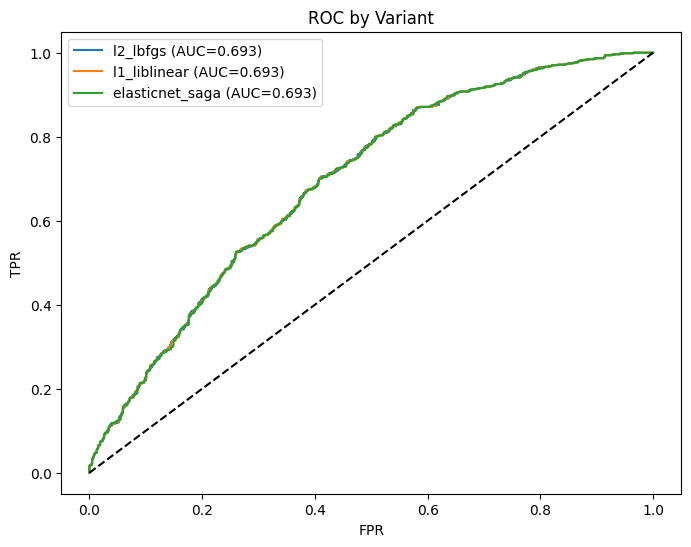

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibration sigmoid: Brier=0.235, ECE=0.114
Calibration isotonic: Brier=0.233, ECE=0.107


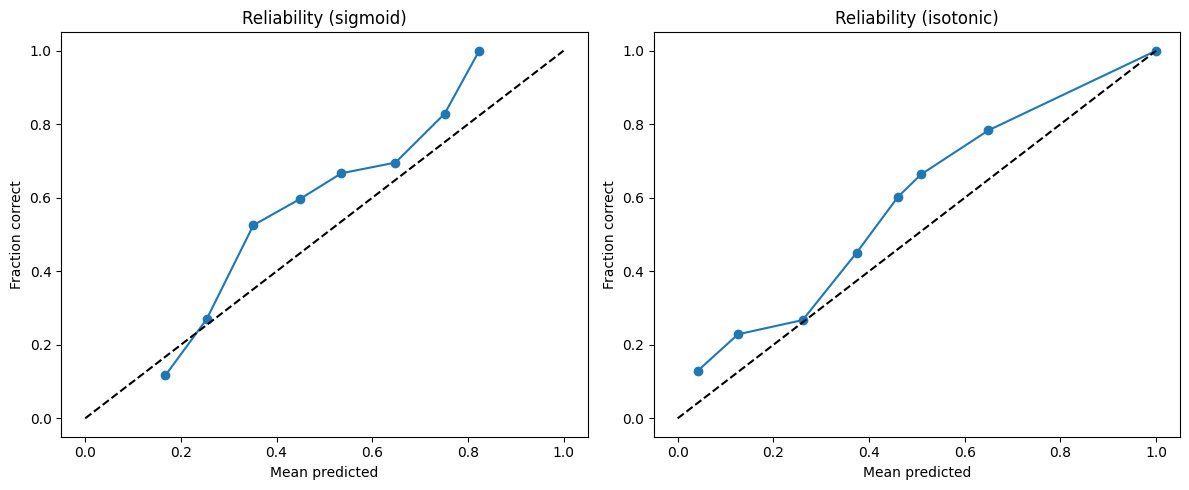

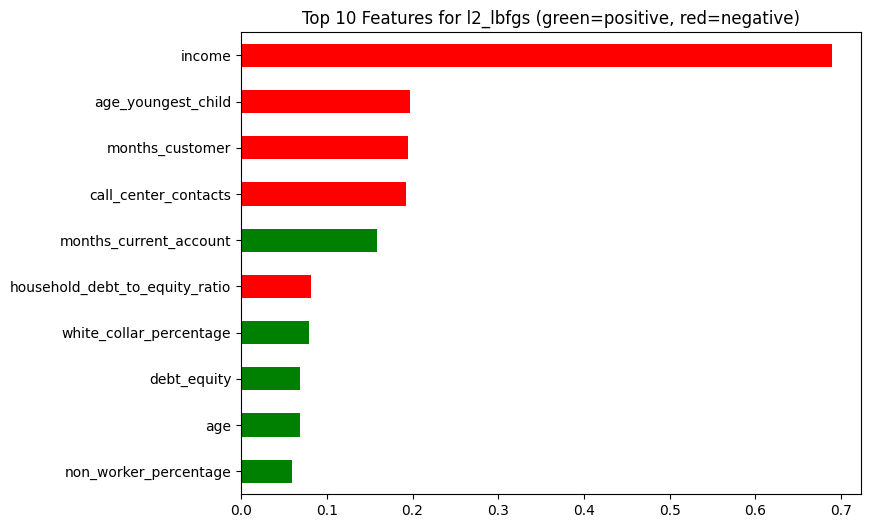

Summary for selected model: {'model_object': LogisticRegression(C=0.1, max_iter=5000), 'selected_model_name': 'l2_lbfgs', 'selected_params': {'C': 0.1}, 'selected_roc_auc': np.float64(0.693), 'calibration_metrics': {'sigmoid': {'brier': np.float64(0.235), 'ece': np.float64(0.114)}, 'isotonic': {'brier': np.float64(0.233), 'ece': np.float64(0.107)}}, 'top_features': income                            0.688890
age_youngest_child                0.197283
months_customer                   0.194693
call_center_contacts              0.191815
months_current_account            0.158122
household_debt_to_equity_ratio    0.081991
white_collar_percentage           0.079137
age                               0.068983
debt_equity                       0.068983
non_worker_percentage             0.059425
dtype: float64}


In [25]:
models_Savings = train_and_evaluate_logistic_models(train_Savings, val_Savings, "Savings")

Training variant: l2_lbfgs
Training variant: l1_liblinear
Training variant: elasticnet_saga


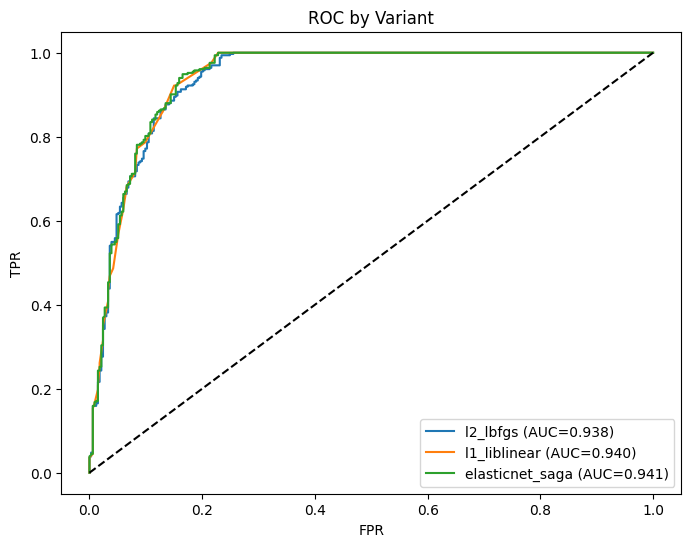

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibration sigmoid: Brier=0.162, ECE=0.181
Calibration isotonic: Brier=0.137, ECE=0.166


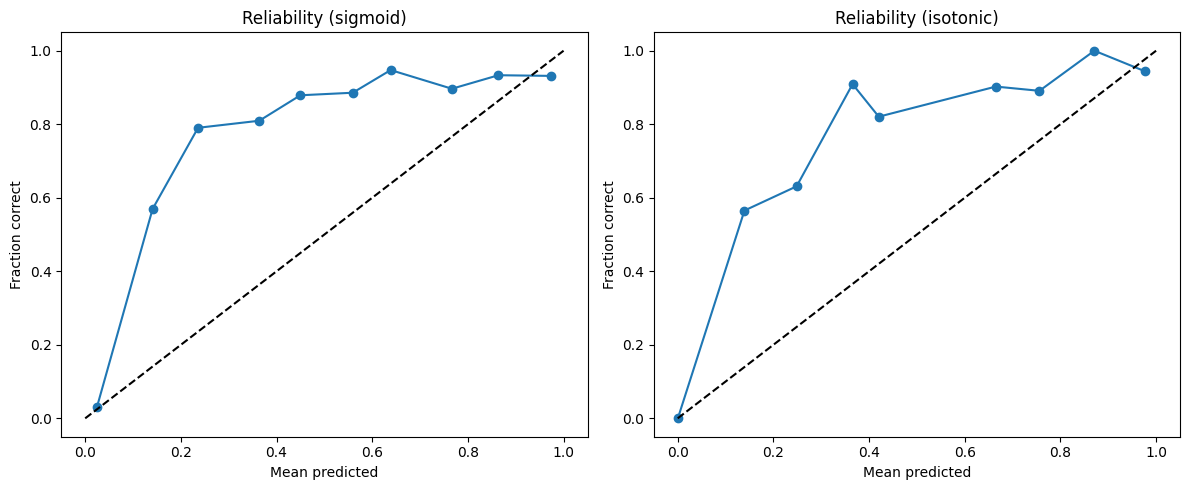

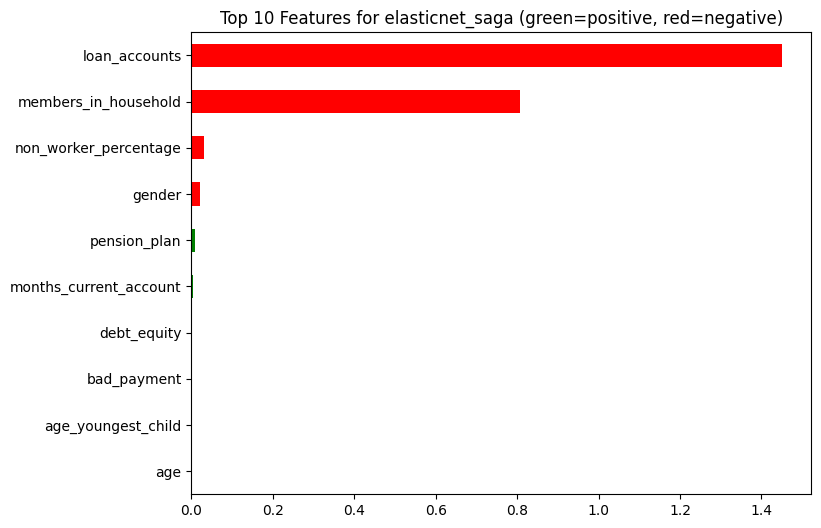

Summary for selected model: {'model_object': LogisticRegression(C=0.01, l1_ratio=0.3, max_iter=5000, penalty='elasticnet',
                   solver='saga'), 'selected_model_name': 'elasticnet_saga', 'selected_params': {'C': 0.01, 'l1_ratio': 0.3}, 'selected_roc_auc': np.float64(0.941), 'calibration_metrics': {'sigmoid': {'brier': np.float64(0.162), 'ece': np.float64(0.181)}, 'isotonic': {'brier': np.float64(0.137), 'ece': np.float64(0.166)}}, 'top_features': loan_accounts             1.450028
members_in_household      0.805964
non_worker_percentage     0.030301
gender                    0.020436
pension_plan              0.008228
months_current_account    0.004924
age                       0.000000
age_youngest_child        0.000000
debt_equity               0.000000
bad_payment               0.000000
dtype: float64}


In [26]:
models_Mortgage = train_and_evaluate_logistic_models(train_Mortgage, val_Mortgage, "Mortgage")